# Question 4 

For this question of predictig the category class for the items.

#### Before we can proceed further, make sure the following requirements are meet : 


1. Open the Jupyter Notebook using the command `jupyter notebook` in the folder containing the folder `Data` and file `Question 4.ipynb`


2. The Anaconda/Python environment has the following libraries installed :
        a. numpy
        b. pandas
        c. os
        d. scikit-learn


3. We have training Data under `Data/train.csv` and testing data under `Data/test.csv`


4. In the train.csv, independent variables(columns from the data) are `item_id, sold_price, price, area_name, condition, size, listing_at, item_tag_hash ` and the dependent variable is ` category_class `

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import f1_score, make_scorer 
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB  # Multinomial Naive Bayes
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import AdaBoostClassifier # Adaboost
from sklearn.decomposition import PCA #Principle Component Analysis

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
pd.options.display.max_columns = None

In [2]:
# check your current directory and correct the path to the test.csv and train.csv
current_path = os.getcwd()
# print(os.getcwd())

In [3]:
# setting the file paths 
master_Train_Data = current_path + '/Data/train.csv'
master_Test_Data = current_path + '/Data/test.csv'

In [4]:
# make sure data.head() and test_data.head() outputs first few rows of the training data before you proceed further
# reading the test dataset which we shall be predicting category class
test_data = pd.read_csv(master_Test_Data, encoding='utf-8')
display(test_data.head())

,item_id,category_class,sold_price,price,area_name,condition,size,listing_at,item_tag_hash
0,6000,NaN,1006,1006,aaa,Like New,4,2017-02-01 13:13:59.048372,dd01903921ea24941c26a48f2cec24e0bb0e8cc7
1,5532,NaN,1149,1147,fff,Fair,3,2017-02-01 08:19:21.532519,784e9240155834852dff458a730cceb50229df32
2,6797,NaN,1044,1042,ddd,Like New,21,2017-02-02 13:27:40.620084,7c9fe6831f52e30e0ede4f8c54fd9bba673e8d8b
3,3325,NaN,1547,1545,kkk,Like New,20,2017-02-02 20:59:30.470107,54c1792c99a96a96a2881600f0cce1d81061e8b8
4,5447,NaN,1015,1014,ddd,Like New,5,2017-01-30 17:43:31.962058,081be7c370bf9e7b4c6e696276c1b2d57623b26b


In [5]:
# reading the training data
data = pd.read_csv(master_Train_Data, encoding='utf-8')
display(data.head())

,item_id,category_class,sold_price,price,area_name,condition,size,listing_at,item_tag_hash
0,7966,0.0,1164,1162,fff,Fair,7,2017-02-01 16:11:18.978516,3ca192bd7558780793444f73366c58d60c9d7775
1,1850,0.0,1005,1004,fff,Fair,3,2017-02-02 14:42:51.693295,fbaacb960902382e4f6c96f2d8f225c24eecadb4
2,7582,2.0,944,944,aaa,Fair,5,2017-02-03 01:55:53.406374,785a7925363bf133a7c5413c563f331c5e02cc69
3,6560,0.0,1068,1067,fff,Fair,7,2017-01-30 23:34:02.268603,f8997252c6e5ae3d950b736e1a81160a2e937a7f
4,7368,3.0,1407,1407,ddd,Good,15,2017-02-03 13:38:37.845010,ca59bcd3da4daac52f3fcfdc0ab963f65cf421bc


### Feature Engineering


Following steps would be taken for feature engineering :

1. Extract timestamp info from `listing_at`

2. Standardising the features `item_id, sold_price, price, size`

3. One Hot Encoding for features `item_tag_hash, condition, area_name`

Things we should be aware of :

1. Same Feature engineering is used for Training data and Testing Data.

2. We standardize and encode the features using the available training data only, we never touch testing data or use any information from testing data.

3. There are values under item_tag_hash,item_id,etc. which are never encountered in training data but are present in testing data, this might leads to miss classification (in prediction.csv) of the testing data but we should be okay with that as that is happening due to label values which were never encountered in training data. 

##### Note
    Training Data : train.csv
    Test Data : test.csv


In [6]:
# Extracting useful information from the datetime field : listing_at
data['listing_at'] = pd.to_datetime(data['listing_at'], format='%Y-%m-%d %H:%M:%S.%f')
data['month'] = data['listing_at'].dt.month
data['year'] = data['listing_at'].dt.year
data['day'] = data['listing_at'].dt.day
data['minute'] = data['listing_at'].dt.minute
data['hour'] = data['listing_at'].dt.hour
data['weekday'] = data['listing_at'].dt.weekday

test_data['listing_at'] = pd.to_datetime(test_data['listing_at'], format='%Y-%m-%d %H:%M:%S.%f')
test_data['month'] = test_data['listing_at'].dt.month
test_data['year'] = test_data['listing_at'].dt.year
test_data['day'] = test_data['listing_at'].dt.day
test_data['minute'] = test_data['listing_at'].dt.minute
test_data['hour'] = test_data['listing_at'].dt.hour
test_data['weekday'] = test_data['listing_at'].dt.weekday

# Converting category_class to int
data['category_class'] = data.category_class.astype(int)


# Standardizing independent variables `item_id, sold_price, price, size`
# item_ID
data['item_id'] = data.item_id.astype(float)
test_data['item_id'] = test_data.item_id.astype(float)
std_item_id = StandardScaler().fit(data.item_id.values.reshape(-1, 1))

std_item_id_results = std_item_id.transform(data.item_id.values.reshape(-1, 1))
item_id_stardardized = pd.DataFrame(std_item_id_results, columns=['std_item_id'])
data = pd.merge(data, item_id_stardardized, left_index=True, right_index=True)

std_test_item_id_results = std_item_id.transform(test_data.item_id.values.reshape(-1, 1))
test_item_id_stardardized = pd.DataFrame(std_test_item_id_results, columns=['std_item_id'])
test_data = pd.merge(test_data, test_item_id_stardardized, left_index=True, right_index=True)

# sold_price
data['sold_price'] = data.sold_price.astype(float)
test_data['sold_price'] = test_data.sold_price.astype(float)
std_sold_price = StandardScaler().fit(data.sold_price.values.reshape(-1, 1))

std_sold_price_results = std_sold_price.transform(data.sold_price.values.reshape(-1, 1))
sold_price_stardardized = pd.DataFrame(std_sold_price_results, columns=['std_sold_price'])
data = pd.merge(data, sold_price_stardardized, left_index=True, right_index=True)

std_test_sold_price_results = std_sold_price.transform(test_data.sold_price.values.reshape(-1, 1))
test_sold_price_stardardized = pd.DataFrame(std_test_sold_price_results, columns=['std_sold_price'])
test_data = pd.merge(test_data, test_sold_price_stardardized, left_index=True, right_index=True)

# price
data['price'] = data.price.astype(float)
test_data['price'] = test_data.price.astype(float)
std_price = StandardScaler().fit(data.price.values.reshape(-1, 1))

std_price_results = std_price.transform(data.price.values.reshape(-1, 1))
price_stardardized = pd.DataFrame(std_price_results, columns=['std_price'])
data = pd.merge(data, price_stardardized, left_index=True, right_index=True)

std_test_price_results = std_price.transform(test_data.price.values.reshape(-1, 1))
test_price_stardardized = pd.DataFrame(std_test_price_results, columns=['std_price'])
test_data = pd.merge(test_data, test_price_stardardized, left_index=True, right_index=True)

# size
data['size'] = data['size'].astype(float)
test_data['size'] = test_data['size'].astype(float)
std_size = StandardScaler().fit(data['size'].values.reshape(-1, 1))

std_size_results = std_size.transform(data['size'].values.reshape(-1, 1))
size_stardardized = pd.DataFrame(std_size_results, columns=['std_size'])
data = pd.merge(data, size_stardardized, left_index=True, right_index=True)

std_test_size_results = std_size.transform(test_data['size'].values.reshape(-1, 1))
test_size_stardardized = pd.DataFrame(std_test_size_results, columns=['std_size'])
test_data = pd.merge(test_data, test_size_stardardized, left_index=True, right_index=True)

# Encoding item_tag_hash data using One-Hot Encoding  
lb_item_hash_labels = LabelBinarizer().fit(data["item_tag_hash"])

lb_results_item_hash_labels = lb_item_hash_labels.transform(data["item_tag_hash"])
item_hash_labels = pd.DataFrame(lb_results_item_hash_labels, columns=lb_item_hash_labels.classes_)
data = pd.merge(data, item_hash_labels, left_index=True, right_index=True)

lb_results_test_item_hash_labels = lb_item_hash_labels.transform(test_data["item_tag_hash"])
test_item_hash_labels = pd.DataFrame(lb_results_test_item_hash_labels, columns=lb_item_hash_labels.classes_)
test_data = pd.merge(test_data, test_item_hash_labels, left_index=True, right_index=True)

# Encoding condition data using One-Hot Encoding 
lb_condition = LabelBinarizer().fit(data["condition"])

lb_results_condition = lb_condition.transform(data["condition"])
condition_labels = pd.DataFrame(lb_results_condition, columns=lb_condition.classes_)
data = pd.merge(data, condition_labels, left_index=True, right_index=True)

lb_results_test_condition = lb_condition.transform(test_data["condition"])
test_condition_labels = pd.DataFrame(lb_results_test_condition, columns=lb_condition.classes_)
test_data = pd.merge(test_data, test_condition_labels, left_index=True, right_index=True)

# Encoding area_name data using One-Hot Encoding 
lb_area_name = LabelBinarizer().fit(data["area_name"])

lb_results_area_name = lb_area_name.transform(data["area_name"])
area_name_labels = pd.DataFrame(lb_results_area_name, columns=lb_area_name.classes_)
data = pd.merge(data, area_name_labels, left_index=True, right_index=True)

lb_results_test_area_name = lb_area_name.transform(test_data["area_name"])
test_area_name_labels = pd.DataFrame(lb_results_test_area_name, columns=lb_area_name.classes_)
test_data = pd.merge(test_data, test_area_name_labels, left_index=True, right_index=True)

In [7]:
# Make sure data is as per our requirement
display(data.head())

,item_id,category_class,sold_price,price,area_name,condition,size,listing_at,item_tag_hash,month,year,day,minute,hour,weekday,std_item_id,std_sold_price,std_price,std_size,00e263ff6806064c016a643c6587b0d607a6a42d,00fd4b4549a1094aae926ef62e9dbd3cdcc2e456,0104cf3b45056589309effd4d0889e430018b490,0200320ae3bc247e747ef93e3259bc29ddf53392,0284938375fd54f17c4331b8ef9f686bfbda02c3,02ef6a4d5e9b6440ee4513baf40746cb8e872fe4,02f84308fab673d8332e1ab780a8ade20987e925,0477d720adf7c715b04850723531a5fb1bc5334b,04b69e5006d308a60f286c6d87138324d3c745c6,05fa2de99c48086b28d6e7a491a75f6f313af79d,070dafcb55881e67b7fce04cfb94faa33639b865,071819749594ed380380dca6aed0f24e25cc9269,07f97cc68eebf81afcd32f6fc0aad7e1f17e0c00,081be7c370bf9e7b4c6e696276c1b2d57623b26b,0aec17ce3bff113e1c7c16e9d9dcaf90bf590974,0cf950b5e4d2ebd7c978c76091ddce6176845697,0f23eb04fa3d66bce3cb03de0629ac1b4fd32bbb,0fb0a8a62cbe899f9c109e5ccf6d5f3b35e33f38,128351137a9c47206c4507dcf2e6fbeeca3a9079,138825ed8f4199d67f9ca400b795b65fec1158ac,14b21325096dd31c90a39900a910122c4d9fe3d9,1592af7e76a7114b4f9beea0be4746f59ada13a6,16da813bd551ff6880e9c1bf6ceb03103ef69db4,17cc4efa7bf7d9e63c99683dd9d8f53590b8fbf5,183723726a927563ad46963f2138cc147d04cea0,1955bfd4523499c91e72d5c446d0d74cccaa5275,1966e694bad90686516f99cdf432800fdca39290,1c602ebc50cdb2284e1383ee41edcfe2344b11b5,1c90b882d4ac9c7d95d597bd8b37e3bfa36aec00,1ccacea16652f70da4bfc9232ee20176fe1dc596,1eb904b6d0c2a41af59e2d1fdd0e10624d94c81a,1f6ae7aaf57c91eff8b09946b2fdf0abd67ac2cf,1ff73fddc94ef96b107787b28b5a5c931b3c761b,23a63310b8e95a3702b44b2f22f3248de1561e88,23e24d90c6975b633f20329226281e642e52ab03,259fe583ddd64df1efa6b2cbf7a1afae427cfa5d,25c65868b540200530fe4d75eb95a9a92c0c76ce,27b37cbcd1da7b04f8f78c990fe964c5804e0506,282c0a20f0520a152c89d8c0489426c0668ca495,290448489a06c6a2dc62e82491212444bd6e341f,2b348a807fba80c79943ffd86758097907a6af79,2b669c9296380e84b1308058c9c5e6917a9510e9,2b9a620b52d24fbdc2b34fb350a34367af53f3c8,2ce518699373ae57c7868a65c4c16d869de5e99b,2e2f7b99fbabb51ec37d8f54b164f309b2a6fc36,2e5a616a2cb3b91852eafe6c9f29c186cc2efd2e,2f70e239c7a5d80384275be451075e4cb7125e9e,30b601f0cbe127b082649fe6fcd93fa86c798107,316b44139a9742cfca5f9c640c47f008f6b73c1b,31e32558fdf2acfa6e47afefa271580600d36202,3ac0b1284201deeda8488a82e2b9b8c11e5d51b4,3aec82c18ccca37a61500a2c658e353667387d9d,3b928622f8479780e1593e188d5315edb7d6f786,3c19eb2961d9d449e857615c28aa47615562bc87,3c457ce18c2e37a4437e0201076ad638367ef0ea,3c4840cf1e3a9541b48135f0467d4846df6e2781,3ca192bd7558780793444f73366c58d60c9d7775,3d41b7fd29fc9b4ab18b63e1727b59b9eb5df1e2,4080612570be15e797c5dae4449e556f77faa2fa,415d2e4353963c539961c46ad289844f4093ba96,418e19155782fc7f12ced8332c8ed025aec227a5,45ce120feaa2c1a2bb53db6c8fb833e58d6bb661,4a4ab45448022f0c738fe9e310148ea1eb7f856b,4b19229e380e9ca29673fdb967fd09cdcf4b5b44,4b3dd95e69e77efeaa3844fd6f6f6ffc5c3bd3f1,4b7af5bd2d1026517f203f379e660fe2337a3e33,4f221ee9a76b15f3f2737e7344ca4453902fb586,4f2b344c5268b61fb41f14c640aeaf89bb7ae6d7,533958a2148aa8a3466fa3a8340d51e28294f41d,5378c3d8a9417d31d1abdb3da9ffb909420656eb,5410535eba45bdd70048c12ae294f3caeddbe6ca,54164c3db2c5171b138c809d3cbe7a6637c31cbf,54c1792c99a96a96a2881600f0cce1d81061e8b8,54ea9be9d0b2076fa355586c14cc03b84ad13c70,54f9c5db018042c5624c67dc1de588c11164e3ac,551220deeb362077f5df356bdebaf94f34f93f0c,5527e76c85e5b71c6defa5f0099519b1d67b4627,566ee6d19fef04459d959b08349d6c07b3a309a2,578d9283ca503d77b707716d16f3ae71036236d2,599e9ef3575ae3622fe4bc5b1b01c3705a7e848c,5bbd5046c9b461ca6f1549f3f39c240a9c5702f9,6185b6dc968a9507570a4bcf063dd40be8d62989,619b7f2c7440776e5362a04735de28763ff332d8,64784bedd53258d0152783e812438f26f69da48c,662791b56c06d86d3c0cb16e8163662dd014fd9f,685df181be80ff8d2018d3ff7c61f12c471005d2,6896ddc64ef4051e872b1e3b3b37d25e74f3c335,69981d3a5bbf8a2ba25db9541830318a04450ec5,6a08d626bc555a03f727670d5b358610a093cfb5,6ab9e3dd3a09945b25c4ab04a708c23b087fe7e6,6b4142e2e97b851a319b0fcab23709b40e3fc19f,6c201efaf928c4db315bee1e4002a646d5714f13,6c8e459f96d9cf05e1fac5432df1066b42609e52,709c7dbb3799c8c

In [8]:
display(test_data.head())

,item_id,category_class,sold_price,price,area_name,condition,size,listing_at,item_tag_hash,month,year,day,minute,hour,weekday,std_item_id,std_sold_price,std_price,std_size,00e263ff6806064c016a643c6587b0d607a6a42d,00fd4b4549a1094aae926ef62e9dbd3cdcc2e456,0104cf3b45056589309effd4d0889e430018b490,0200320ae3bc247e747ef93e3259bc29ddf53392,0284938375fd54f17c4331b8ef9f686bfbda02c3,02ef6a4d5e9b6440ee4513baf40746cb8e872fe4,02f84308fab673d8332e1ab780a8ade20987e925,0477d720adf7c715b04850723531a5fb1bc5334b,04b69e5006d308a60f286c6d87138324d3c745c6,05fa2de99c48086b28d6e7a491a75f6f313af79d,070dafcb55881e67b7fce04cfb94faa33639b865,071819749594ed380380dca6aed0f24e25cc9269,07f97cc68eebf81afcd32f6fc0aad7e1f17e0c00,081be7c370bf9e7b4c6e696276c1b2d57623b26b,0aec17ce3bff113e1c7c16e9d9dcaf90bf590974,0cf950b5e4d2ebd7c978c76091ddce6176845697,0f23eb04fa3d66bce3cb03de0629ac1b4fd32bbb,0fb0a8a62cbe899f9c109e5ccf6d5f3b35e33f38,128351137a9c47206c4507dcf2e6fbeeca3a9079,138825ed8f4199d67f9ca400b795b65fec1158ac,14b21325096dd31c90a39900a910122c4d9fe3d9,1592af7e76a7114b4f9beea0be4746f59ada13a6,16da813bd551ff6880e9c1bf6ceb03103ef69db4,17cc4efa7bf7d9e63c99683dd9d8f53590b8fbf5,183723726a927563ad46963f2138cc147d04cea0,1955bfd4523499c91e72d5c446d0d74cccaa5275,1966e694bad90686516f99cdf432800fdca39290,1c602ebc50cdb2284e1383ee41edcfe2344b11b5,1c90b882d4ac9c7d95d597bd8b37e3bfa36aec00,1ccacea16652f70da4bfc9232ee20176fe1dc596,1eb904b6d0c2a41af59e2d1fdd0e10624d94c81a,1f6ae7aaf57c91eff8b09946b2fdf0abd67ac2cf,1ff73fddc94ef96b107787b28b5a5c931b3c761b,23a63310b8e95a3702b44b2f22f3248de1561e88,23e24d90c6975b633f20329226281e642e52ab03,259fe583ddd64df1efa6b2cbf7a1afae427cfa5d,25c65868b540200530fe4d75eb95a9a92c0c76ce,27b37cbcd1da7b04f8f78c990fe964c5804e0506,282c0a20f0520a152c89d8c0489426c0668ca495,290448489a06c6a2dc62e82491212444bd6e341f,2b348a807fba80c79943ffd86758097907a6af79,2b669c9296380e84b1308058c9c5e6917a9510e9,2b9a620b52d24fbdc2b34fb350a34367af53f3c8,2ce518699373ae57c7868a65c4c16d869de5e99b,2e2f7b99fbabb51ec37d8f54b164f309b2a6fc36,2e5a616a2cb3b91852eafe6c9f29c186cc2efd2e,2f70e239c7a5d80384275be451075e4cb7125e9e,30b601f0cbe127b082649fe6fcd93fa86c798107,316b44139a9742cfca5f9c640c47f008f6b73c1b,31e32558fdf2acfa6e47afefa271580600d36202,3ac0b1284201deeda8488a82e2b9b8c11e5d51b4,3aec82c18ccca37a61500a2c658e353667387d9d,3b928622f8479780e1593e188d5315edb7d6f786,3c19eb2961d9d449e857615c28aa47615562bc87,3c457ce18c2e37a4437e0201076ad638367ef0ea,3c4840cf1e3a9541b48135f0467d4846df6e2781,3ca192bd7558780793444f73366c58d60c9d7775,3d41b7fd29fc9b4ab18b63e1727b59b9eb5df1e2,4080612570be15e797c5dae4449e556f77faa2fa,415d2e4353963c539961c46ad289844f4093ba96,418e19155782fc7f12ced8332c8ed025aec227a5,45ce120feaa2c1a2bb53db6c8fb833e58d6bb661,4a4ab45448022f0c738fe9e310148ea1eb7f856b,4b19229e380e9ca29673fdb967fd09cdcf4b5b44,4b3dd95e69e77efeaa3844fd6f6f6ffc5c3bd3f1,4b7af5bd2d1026517f203f379e660fe2337a3e33,4f221ee9a76b15f3f2737e7344ca4453902fb586,4f2b344c5268b61fb41f14c640aeaf89bb7ae6d7,533958a2148aa8a3466fa3a8340d51e28294f41d,5378c3d8a9417d31d1abdb3da9ffb909420656eb,5410535eba45bdd70048c12ae294f3caeddbe6ca,54164c3db2c5171b138c809d3cbe7a6637c31cbf,54c1792c99a96a96a2881600f0cce1d81061e8b8,54ea9be9d0b2076fa355586c14cc03b84ad13c70,54f9c5db018042c5624c67dc1de588c11164e3ac,551220deeb362077f5df356bdebaf94f34f93f0c,5527e76c85e5b71c6defa5f0099519b1d67b4627,566ee6d19fef04459d959b08349d6c07b3a309a2,578d9283ca503d77b707716d16f3ae71036236d2,599e9ef3575ae3622fe4bc5b1b01c3705a7e848c,5bbd5046c9b461ca6f1549f3f39c240a9c5702f9,6185b6dc968a9507570a4bcf063dd40be8d62989,619b7f2c7440776e5362a04735de28763ff332d8,64784bedd53258d0152783e812438f26f69da48c,662791b56c06d86d3c0cb16e8163662dd014fd9f,685df181be80ff8d2018d3ff7c61f12c471005d2,6896ddc64ef4051e872b1e3b3b37d25e74f3c335,69981d3a5bbf8a2ba25db9541830318a04450ec5,6a08d626bc555a03f727670d5b358610a093cfb5,6ab9e3dd3a09945b25c4ab04a708c23b087fe7e6,6b4142e2e97b851a319b0fcab23709b40e3fc19f,6c201efaf928c4db315bee1e4002a646d5714f13,6c8e459f96d9cf05e1fac5432df1066b42609e52,709c7dbb3799c8c

In [9]:
# Listing all the columns
for x in data.columns:
    print(x)

item_id
category_class
sold_price
price
area_name
condition
size
listing_at
item_tag_hash
month
year
day
minute
hour
weekday
std_item_id
std_sold_price
std_price
std_size
00e263ff6806064c016a643c6587b0d607a6a42d
00fd4b4549a1094aae926ef62e9dbd3cdcc2e456
0104cf3b45056589309effd4d0889e430018b490
0200320ae3bc247e747ef93e3259bc29ddf53392
0284938375fd54f17c4331b8ef9f686bfbda02c3
02ef6a4d5e9b6440ee4513baf40746cb8e872fe4
02f84308fab673d8332e1ab780a8ade20987e925
0477d720adf7c715b04850723531a5fb1bc5334b
04b69e5006d308a60f286c6d87138324d3c745c6
05fa2de99c48086b28d6e7a491a75f6f313af79d
070dafcb55881e67b7fce04cfb94faa33639b865
071819749594ed380380dca6aed0f24e25cc9269
07f97cc68eebf81afcd32f6fc0aad7e1f17e0c00
081be7c370bf9e7b4c6e696276c1b2d57623b26b
0aec17ce3bff113e1c7c16e9d9dcaf90bf590974
0cf950b5e4d2ebd7c978c76091ddce6176845697
0f23eb04fa3d66bce3cb03de0629ac1b4fd32bbb
0fb0a8a62cbe899f9c109e5ccf6d5f3b35e33f38
128351137a9c47206c4507dcf2e6fbeeca3a9079
138825ed8f4199d67f9ca400b795b65fec1158ac
14b213250

In [10]:
# Shape of the dataframe
print(data.shape)

(700, 220)


### Data Analysis

In [11]:
aggregations_1 = {
    'category_class':['count'],
    'sold_price': [ 'mean', 'std'],
    'price': [ 'mean', 'std'],
    'size': ['mean', 'std']
}

data.groupby(['category_class']).agg(aggregations_1)

category_class   sold_price                    price  \
                        count         mean         std         mean   
category_class                                                        
0                         226  1012.814159  111.392882  1011.800885   
1                         149  1280.919463  177.565653  1335.000000   
2                         157   990.929936  105.925598   989.917197   
3                          86  1305.674419  209.258492  1430.523256   
4                          82   937.439024  129.231069   936.524390   

                                 size             
                       std       mean        std  
category_class                                    
0               111.382425   5.942478   3.887445  
1               324.845140  14.355705   6.934124  
2               105.946162   5.643312   3.647993  
3               453.097256  20.337209  10.385069  
4               129.021122   5.707317   3.202961

In [12]:
aggregations_2 = {
    'hour': ['count']
}
# displaying count of a given hour of listing  across different category_class
hours_df = data.groupby(['category_class', 'hour']).agg(aggregations_2).unstack().fillna(0)
hours_df.loc['Total'] = hours_df.sum()
hours_df['Total'] = hours_df.sum(axis=1)
display(hours_df)

# displaying percentages of a given hour of listing across different  category_class
hours_df = hours_df.drop('Total', axis=0)
hours_df = hours_df.drop('Total', axis=1)
percentage_hours_df = hours_df.apply(lambda g : 100*g/g.sum()).rename(columns={'count':'Percentage'})
percentage_hours_df.loc['Total'] = percentage_hours_df.sum()
display(percentage_hours_df)
# column wise sum adds upto 100

hour                                                        \
               count                                                         
hour               0     1     2     3     4     5     6     7     8     9   
category_class                                                               
0               11.0   5.0  14.0   5.0   8.0  10.0   8.0   9.0   8.0   4.0   
1                7.0   5.0   4.0   8.0   8.0   9.0   6.0  10.0   3.0   9.0   
2                3.0   6.0  13.0   6.0   5.0   9.0   7.0   9.0   6.0   8.0   
3                5.0   4.0   6.0   5.0   4.0   1.0   1.0   2.0   3.0   3.0   
4                1.0   2.0   4.0   3.0   5.0   3.0   4.0   3.0   1.0   6.0   
Total           27.0  22.0  41.0  27.0  30.0  32.0  26.0  33.0  21.0  30.0   

                                                                            \
                                                                             
hour              10    11    12    13    14    15    16    17    18    19   
category_class                                                               
0                6.0  10.0   8.0   9.0   9.0  11.0  14.0   9.0  17.0  15.0   
1                4.0   6.0   7.0   7.0  12.0   6.0   5.0   7.0   6.0   4.0   
2                7.0   5.0   5.0   6.0   8.0   4.0   7.0   7.0   4.0   6.0   
3                7.0   3.0   5.0   5.0   2.0   3.0   7.0   2.0   2.0   3.0   
4                3.0   5.0   3.0   5.0   4.0   3.0   3.0   5.0   0.0   2.0   
Total           27.0  29.0  28.0  32.0  35.0  27.0  36.0  30.0  29.0  30.0   

                                        Total  
                                               
hour              20    21    22    23         
category_class                                 
0                9.0   9.0  10.0   8.0  226.0  
1                3.0   5.0   4.0   4.0  149.0  
2                4.0   8.0   7.0   7.0  157.0  
3                6.0   3.0   1.0   3.0   86.0  
4                4.0   3.0   3.0   7.0   82.0  
Total           26.0  28.0  25.0  29.0  700.0

hour                                                  \
                Percentage                                                   
hour                    0           1           2           3           4    
category_class                                                               
0                40.740741   22.727273   34.146341   18.518519   26.666667   
1                25.925926   22.727273    9.756098   29.629630   26.666667   
2                11.111111   27.272727   31.707317   22.222222   16.666667   
3                18.518519   18.181818   14.634146   18.518519   13.333333   
4                 3.703704    9.090909    9.756098   11.111111   16.666667   
Total           100.000000  100.000000  100.000000  100.000000  100.000000   

                                                                         \
                                                                          
hour                 5           6           7           8           9    
category_class                                                            
0                31.250   30.769231   27.272727   38.095238   13.333333   
1                28.125   23.076923   30.303030   14.285714   30.000000   
2                28.125   26.923077   27.272727   28.571429   26.666667   
3                 3.125    3.846154    6.060606   14.285714   10.000000   
4                 9.375   15.384615    9.090909    4.761905   20.000000   
Total           100.000  100.000000  100.000000  100.000000  100.000000   

                                                                         \
                                                                          
hour                    10          11          12       13          14   
category_class                                                            
0                22.222222   34.482759   28.571429   28.125   25.714286   
1                14.814815   20.689655   25.000000   21.875   34.285714   
2                25.925926   17.241379   17.857143   18.750   22.857143   
3                25.925926   10.344828   17.857143   15.625    5.714286   
4                11.111111   17.241379   10.714286   15.625   11.428571   
Total           100.000000  100.000000  100.000000  100.000  100.000000   

                                                                            \
                                                                             
hour                    15          16          17          18          19   
category_class                                                               
0                40.740741   38.888889   30.000000   58.620690   50.000000   
1                22.222222   13.888889   23.333333   20.689655   13.333333   
2                14.814815   19.444444   23.333333   13.793103   20.000000   
3                11.111111   19.444444    6.666667    6.896552   10.000000   
4                11.111111    8.333333   16.666667    0.000000    6.666667   
Total           100.000000  100.000000  100.000000  100.000000  100.000000   

                                                           
                                                           
hour                    20          21     22          23  
category_class                                             
0                34.615385   32.142857   40.0   27.586207  
1                11.538462   17.857143   16.0   13.793103  
2                15.384615   28.571429   28.0   24.137931  
3                23.076923   10.714286    4.0   10.344828  
4                15.384615   10.714286   12.0   24.137931  
Total           100.000000  100.000000  100.0  100.000000

In [13]:
aggregations_3 = {
    'category_class': ['count']
}
# displaying count of a given categories_class across different area_name 
area_name_df = data.groupby(['area_name', 'category_class']).agg(aggregations_3).unstack()
area_name_df.loc['Total'] = area_name_df.sum()
area_name_df['Total'] = area_name_df.sum(axis=1)
display(area_name_df)

# displaying percentage of a given categories_class across different area_name
area_name_df = area_name_df.drop('Total', axis=0)
area_name_df = area_name_df.drop('Total', axis=1)
percentage_area_name_df = area_name_df.apply(lambda g : 100*g/g.sum()).rename(columns={'count':'Percentage'})
percentage_area_name_df.loc['Total'] = percentage_area_name_df.sum()
display(percentage_area_name_df)
# column wise sum adds upto 100

aggregations_4 = {
    'area_name': ['count']
} 
area_name_df_transpose = data.groupby(['category_class', 'area_name']).agg(aggregations_4).unstack()
# displaying percentage of a given area_name across different category_class 
percentage_area_name_df_transpose = area_name_df_transpose.apply(lambda g : 100*g/g.sum()).rename(columns={'count':'Percentage'})
percentage_area_name_df_transpose.loc['Total'] = percentage_area_name_df_transpose.sum()
display(percentage_area_name_df_transpose)
# column wise sum adds upto 100

category_class                   Total
                        count                        
category_class              0    1    2   3   4      
area_name                                            
aaa                        23    8   18   6  11    66
bbb                        27   12   12   4  13    68
ccc                        38   10   11   5  12    76
ddd                        24   13   23   5   9    74
eee                        25   11    5   7  17    65
fff                        26   15   12   5   8    66
ggg                        19   14   21  16   8    78
hhh                        12   16   15  17   2    62
jjj                        13   23   23  11   1    71
kkk                        19   27   17  10   1    74
Total                     226  149  157  86  82   700

category_class                                                
                   Percentage                                                
category_class              0           1           2           3           4
area_name                                                                    
aaa                 10.176991    5.369128   11.464968    6.976744   13.414634
bbb                 11.946903    8.053691    7.643312    4.651163   15.853659
ccc                 16.814159    6.711409    7.006369    5.813953   14.634146
ddd                 10.619469    8.724832   14.649682    5.813953   10.975610
eee                 11.061947    7.382550    3.184713    8.139535   20.731707
fff                 11.504425   10.067114    7.643312    5.813953    9.756098
ggg                  8.407080    9.395973   13.375796   18.604651    9.756098
hhh                  5.309735   10.738255    9.554140   19.767442    2.439024
jjj                  5.752212   15.436242   14.649682   12.790698    1.219512
kkk                  8.407080   18.120805   10.828025   11.627907    1.219512
Total              100.000000  100.000000  100.000000  100.000000  100.000000

area_name                                                  \
                Percentage                                                   
area_name              aaa         bbb         ccc         ddd         eee   
category_class                                                               
0                34.848485   39.705882   50.000000   32.432432   38.461538   
1                12.121212   17.647059   13.157895   17.567568   16.923077   
2                27.272727   17.647059   14.473684   31.081081    7.692308   
3                 9.090909    5.882353    6.578947    6.756757   10.769231   
4                16.666667   19.117647   15.789474   12.162162   26.153846   
Total           100.000000  100.000000  100.000000  100.000000  100.000000   

                                                                            
                                                                            
area_name              fff         ggg         hhh         jjj         kkk  
category_class                                                              
0                39.393939   24.358974   19.354839   18.309859   25.675676  
1                22.727273   17.948718   25.806452   32.394366   36.486486  
2                18.181818   26.923077   24.193548   32.394366   22.972973  
3                 7.575758   20.512821   27.419355   15.492958   13.513514  
4                12.121212   10.256410    3.225806    1.408451    1.351351  
Total           100.000000  100.000000  100.000000  100.000000  100.000000

In [14]:
# displaying count of a given categories_class across different weekday
weekday_df = data.groupby(['weekday', 'category_class']).agg(aggregations_3).unstack()
weekday_df.loc['Total'] = weekday_df.sum()
weekday_df['Total'] = weekday_df.sum(axis=1)
display(weekday_df)

# displaying percentage of a given categories_class across different weekday 
weekday_df = weekday_df.drop('Total', axis=0)
weekday_df = weekday_df.drop('Total', axis=1)
percentage_weekday_df = weekday_df.apply(lambda g : 100*g/g.sum()).rename(columns={'count':'Percentage'})
percentage_weekday_df.loc['Total'] = percentage_weekday_df.sum()
display(percentage_weekday_df)
# column wise sum adds upto 100

aggregations_5 = {
    'weekday': ['count']
} 
weekday_df_transpose = data.groupby(['category_class', 'weekday']).agg(aggregations_5).unstack()
# displaying percentage of a given weekday across different category_class 
percentage_weekday_df_transpose = weekday_df_transpose.apply(lambda g : 100*g/g.sum()).rename(columns={'count':'Percentage'})
percentage_weekday_df_transpose.loc['Total'] = percentage_weekday_df_transpose.sum()
display(percentage_weekday_df_transpose)
# column wise sum adds upto 100

category_class                   Total
                        count                        
category_class              0    1    2   3   4      
weekday                                              
0                          32   37   29   3  20   121
1                          40   39   45   9  25   158
2                          65   34   33  28  13   173
3                          45   20   23  27   8   123
4                          25    7   11  14   1    58
5                           4    4    3   3   1    15
6                          15    8   13   2  14    52
Total                     226  149  157  86  82   700

category_class                                                
                   Percentage                                                
category_class              0           1           2           3           4
weekday                                                                      
0                   14.159292   24.832215   18.471338    3.488372   24.390244
1                   17.699115   26.174497   28.662420   10.465116   30.487805
2                   28.761062   22.818792   21.019108   32.558140   15.853659
3                   19.911504   13.422819   14.649682   31.395349    9.756098
4                   11.061947    4.697987    7.006369   16.279070    1.219512
5                    1.769912    2.684564    1.910828    3.488372    1.219512
6                    6.637168    5.369128    8.280255    2.325581   17.073171
Total              100.000000  100.000000  100.000000  100.000000  100.000000

weekday                                                  \
                Percentage                                                   
weekday                  0           1           2           3           4   
category_class                                                               
0                26.446281   25.316456   37.572254   36.585366   43.103448   
1                30.578512   24.683544   19.653179   16.260163   12.068966   
2                23.966942   28.481013   19.075145   18.699187   18.965517   
3                 2.479339    5.696203   16.184971   21.951220   24.137931   
4                16.528926   15.822785    7.514451    6.504065    1.724138   
Total           100.000000  100.000000  100.000000  100.000000  100.000000   

                                        
                                        
weekday                  5           6  
category_class                          
0                26.666667   28.846154  
1                26.666667   15.384615  
2                20.000000   25.000000  
3                20.000000    3.846154  
4                 6.666667   26.923077  
Total           100.000000  100.000000

In [15]:
# displaying count of a given categories_class across different condition 
condition_df = data.groupby(['condition', 'category_class']).agg(aggregations_3).unstack()
condition_df.loc['Total'] = condition_df.sum()
condition_df['Total'] = condition_df.sum(axis=1)
display(condition_df)

# displaying percentage of a given categories_class across different condition 
condition_df = condition_df.drop('Total', axis=0)
condition_df = condition_df.drop('Total', axis=1)
percentage_condition_df = condition_df.apply(lambda g : 100*g/g.sum()).rename(columns={'count':'Percentage'})
percentage_condition_df.loc['Total'] = percentage_condition_df.sum()
display(percentage_condition_df)
# column wise sum adds upto 100

aggregations_6 = {
    'condition': ['count']
}
condition_df_transpose = data.groupby(['category_class', 'condition']).agg(aggregations_6).unstack()
# displaying percentage of a given condition across different category_class 
percentage_condition_df_transpose = condition_df_transpose.apply(lambda g : 100*g/g.sum()).rename(columns={'count':'Percentage'})
percentage_condition_df_transpose.loc['Total'] = percentage_condition_df_transpose.sum()
display(percentage_condition_df_transpose)
# column wise sum adds upto 100

category_class                   Total
                        count                        
category_class              0    1    2   3   4      
condition                                            
Fair                      113   11   29  29  36   218
Good                       76   58   68  41  29   272
Like New                   37   80   60  16  17   210
Total                     226  149  157  86  82   700

category_class                                                
                   Percentage                                                
category_class              0           1           2           3           4
condition                                                                    
Fair                50.000000    7.382550   18.471338   33.720930   43.902439
Good                33.628319   38.926174   43.312102   47.674419   35.365854
Like New            16.371681   53.691275   38.216561   18.604651   20.731707
Total              100.000000  100.000000  100.000000  100.000000  100.000000

condition                        
                Percentage                        
condition             Fair        Good    Like New
category_class                                    
0                51.834862   27.941176   17.619048
1                 5.045872   21.323529   38.095238
2                13.302752   25.000000   28.571429
3                13.302752   15.073529    7.619048
4                16.513761   10.661765    8.095238
Total           100.000000  100.000000  100.000000

### Selecting the features for the model

In [16]:
# seperating out independent variables and dependent variables
# also filtering out columns we no longer require
independent_variables = data.columns.tolist()
independent_variables.remove('category_class')
independent_variables.remove('listing_at')
independent_variables.remove('year')
independent_variables.remove('item_tag_hash')
independent_variables.remove('condition')
independent_variables.remove('area_name')
independent_variables.remove('price')
independent_variables.remove('item_id')
independent_variables.remove('sold_price')
independent_variables.remove('size')



dependent_variable = ['category_class']

features = data[independent_variables]
label = data[dependent_variable]

test_features = test_data[independent_variables]

In [17]:
features.head()

,month,day,minute,hour,weekday,std_item_id,std_sold_price,std_price,std_size,00e263ff6806064c016a643c6587b0d607a6a42d,00fd4b4549a1094aae926ef62e9dbd3cdcc2e456,0104cf3b45056589309effd4d0889e430018b490,0200320ae3bc247e747ef93e3259bc29ddf53392,0284938375fd54f17c4331b8ef9f686bfbda02c3,02ef6a4d5e9b6440ee4513baf40746cb8e872fe4,02f84308fab673d8332e1ab780a8ade20987e925,0477d720adf7c715b04850723531a5fb1bc5334b,04b69e5006d308a60f286c6d87138324d3c745c6,05fa2de99c48086b28d6e7a491a75f6f313af79d,070dafcb55881e67b7fce04cfb94faa33639b865,071819749594ed380380dca6aed0f24e25cc9269,07f97cc68eebf81afcd32f6fc0aad7e1f17e0c00,081be7c370bf9e7b4c6e696276c1b2d57623b26b,0aec17ce3bff113e1c7c16e9d9dcaf90bf590974,0cf950b5e4d2ebd7c978c76091ddce6176845697,0f23eb04fa3d66bce3cb03de0629ac1b4fd32bbb,0fb0a8a62cbe899f9c109e5ccf6d5f3b35e33f38,128351137a9c47206c4507dcf2e6fbeeca3a9079,138825ed8f4199d67f9ca400b795b65fec1158ac,14b21325096dd31c90a39900a910122c4d9fe3d9,1592af7e76a7114b4f9beea0be4746f59ada13a6,16da813bd551ff6880e9c1bf6ceb03103ef69db4,17cc4efa7bf7d9e63c99683dd9d8f53590b8fbf5,183723726a927563ad46963f2138cc147d04cea0,1955bfd4523499c91e72d5c446d0d74cccaa5275,1966e694bad90686516f99cdf432800fdca39290,1c602ebc50cdb2284e1383ee41edcfe2344b11b5,1c90b882d4ac9c7d95d597bd8b37e3bfa36aec00,1ccacea16652f70da4bfc9232ee20176fe1dc596,1eb904b6d0c2a41af59e2d1fdd0e10624d94c81a,1f6ae7aaf57c91eff8b09946b2fdf0abd67ac2cf,1ff73fddc94ef96b107787b28b5a5c931b3c761b,23a63310b8e95a3702b44b2f22f3248de1561e88,23e24d90c6975b633f20329226281e642e52ab03,259fe583ddd64df1efa6b2cbf7a1afae427cfa5d,25c65868b540200530fe4d75eb95a9a92c0c76ce,27b37cbcd1da7b04f8f78c990fe964c5804e0506,282c0a20f0520a152c89d8c0489426c0668ca495,290448489a06c6a2dc62e82491212444bd6e341f,2b348a807fba80c79943ffd86758097907a6af79,2b669c9296380e84b1308058c9c5e6917a9510e9,2b9a620b52d24fbdc2b34fb350a34367af53f3c8,2ce518699373ae57c7868a65c4c16d869de5e99b,2e2f7b99fbabb51ec37d8f54b164f309b2a6fc36,2e5a616a2cb3b91852eafe6c9f29c186cc2efd2e,2f70e239c7a5d80384275be451075e4cb7125e9e,30b601f0cbe127b082649fe6fcd93fa86c798107,316b44139a9742cfca5f9c640c47f008f6b73c1b,31e32558fdf2acfa6e47afefa271580600d36202,3ac0b1284201deeda8488a82e2b9b8c11e5d51b4,3aec82c18ccca37a61500a2c658e353667387d9d,3b928622f8479780e1593e188d5315edb7d6f786,3c19eb2961d9d449e857615c28aa47615562bc87,3c457ce18c2e37a4437e0201076ad638367ef0ea,3c4840cf1e3a9541b48135f0467d4846df6e2781,3ca192bd7558780793444f73366c58d60c9d7775,3d41b7fd29fc9b4ab18b63e1727b59b9eb5df1e2,4080612570be15e797c5dae4449e556f77faa2fa,415d2e4353963c539961c46ad289844f4093ba96,418e19155782fc7f12ced8332c8ed025aec227a5,45ce120feaa2c1a2bb53db6c8fb833e58d6bb661,4a4ab45448022f0c738fe9e310148ea1eb7f856b,4b19229e380e9ca29673fdb967fd09cdcf4b5b44,4b3dd95e69e77efeaa3844fd6f6f6ffc5c3bd3f1,4b7af5bd2d1026517f203f379e660fe2337a3e33,4f221ee9a76b15f3f2737e7344ca4453902fb586,4f2b344c5268b61fb41f14c640aeaf89bb7ae6d7,533958a2148aa8a3466fa3a8340d51e28294f41d,5378c3d8a9417d31d1abdb3da9ffb909420656eb,5410535eba45bdd70048c12ae294f3caeddbe6ca,54164c3db2c5171b138c809d3cbe7a6637c31cbf,54c1792c99a96a96a2881600f0cce1d81061e8b8,54ea9be9d0b2076fa355586c14cc03b84ad13c70,54f9c5db018042c5624c67dc1de588c11164e3ac,551220deeb362077f5df356bdebaf94f34f93f0c,5527e76c85e5b71c6defa5f0099519b1d67b4627,566ee6d19fef04459d959b08349d6c07b3a309a2,578d9283ca503d77b707716d16f3ae71036236d2,599e9ef3575ae3622fe4bc5b1b01c3705a7e848c,5bbd5046c9b461ca6f1549f3f39c240a9c5702f9,6185b6dc968a9507570a4bcf063dd40be8d62989,619b7f2c7440776e5362a04735de28763ff332d8,64784bedd53258d0152783e812438f26f69da48c,662791b56c06d86d3c0cb16e8163662dd014fd9f,685df181be80ff8d2018d3ff7c61f12c471005d2,6896ddc64ef4051e872b1e3b3b37d25e74f3c335,69981d3a5bbf8a2ba25db9541830318a04450ec5,6a08d626bc555a03f727670d5b358610a093cfb5,6ab9e3dd3a09945b25c4ab04a708c23b087fe7e6,6b4142e2e97b851a319b0fcab23709b40e3fc19f,6c201efaf928c4db315bee1e4002a646d5714f13,6c8e459f96d9cf05e1fac5432df1066b42609e52,709c7dbb3799c8cc779706c907513661df268cbc,70b8dcb93382715a55ce5f2a8356ef5636a2d2da,715e82fa3b623c04f4eb343985db

In [18]:
test_features.head()

,month,day,minute,hour,weekday,std_item_id,std_sold_price,std_price,std_size,00e263ff6806064c016a643c6587b0d607a6a42d,00fd4b4549a1094aae926ef62e9dbd3cdcc2e456,0104cf3b45056589309effd4d0889e430018b490,0200320ae3bc247e747ef93e3259bc29ddf53392,0284938375fd54f17c4331b8ef9f686bfbda02c3,02ef6a4d5e9b6440ee4513baf40746cb8e872fe4,02f84308fab673d8332e1ab780a8ade20987e925,0477d720adf7c715b04850723531a5fb1bc5334b,04b69e5006d308a60f286c6d87138324d3c745c6,05fa2de99c48086b28d6e7a491a75f6f313af79d,070dafcb55881e67b7fce04cfb94faa33639b865,071819749594ed380380dca6aed0f24e25cc9269,07f97cc68eebf81afcd32f6fc0aad7e1f17e0c00,081be7c370bf9e7b4c6e696276c1b2d57623b26b,0aec17ce3bff113e1c7c16e9d9dcaf90bf590974,0cf950b5e4d2ebd7c978c76091ddce6176845697,0f23eb04fa3d66bce3cb03de0629ac1b4fd32bbb,0fb0a8a62cbe899f9c109e5ccf6d5f3b35e33f38,128351137a9c47206c4507dcf2e6fbeeca3a9079,138825ed8f4199d67f9ca400b795b65fec1158ac,14b21325096dd31c90a39900a910122c4d9fe3d9,1592af7e76a7114b4f9beea0be4746f59ada13a6,16da813bd551ff6880e9c1bf6ceb03103ef69db4,17cc4efa7bf7d9e63c99683dd9d8f53590b8fbf5,183723726a927563ad46963f2138cc147d04cea0,1955bfd4523499c91e72d5c446d0d74cccaa5275,1966e694bad90686516f99cdf432800fdca39290,1c602ebc50cdb2284e1383ee41edcfe2344b11b5,1c90b882d4ac9c7d95d597bd8b37e3bfa36aec00,1ccacea16652f70da4bfc9232ee20176fe1dc596,1eb904b6d0c2a41af59e2d1fdd0e10624d94c81a,1f6ae7aaf57c91eff8b09946b2fdf0abd67ac2cf,1ff73fddc94ef96b107787b28b5a5c931b3c761b,23a63310b8e95a3702b44b2f22f3248de1561e88,23e24d90c6975b633f20329226281e642e52ab03,259fe583ddd64df1efa6b2cbf7a1afae427cfa5d,25c65868b540200530fe4d75eb95a9a92c0c76ce,27b37cbcd1da7b04f8f78c990fe964c5804e0506,282c0a20f0520a152c89d8c0489426c0668ca495,290448489a06c6a2dc62e82491212444bd6e341f,2b348a807fba80c79943ffd86758097907a6af79,2b669c9296380e84b1308058c9c5e6917a9510e9,2b9a620b52d24fbdc2b34fb350a34367af53f3c8,2ce518699373ae57c7868a65c4c16d869de5e99b,2e2f7b99fbabb51ec37d8f54b164f309b2a6fc36,2e5a616a2cb3b91852eafe6c9f29c186cc2efd2e,2f70e239c7a5d80384275be451075e4cb7125e9e,30b601f0cbe127b082649fe6fcd93fa86c798107,316b44139a9742cfca5f9c640c47f008f6b73c1b,31e32558fdf2acfa6e47afefa271580600d36202,3ac0b1284201deeda8488a82e2b9b8c11e5d51b4,3aec82c18ccca37a61500a2c658e353667387d9d,3b928622f8479780e1593e188d5315edb7d6f786,3c19eb2961d9d449e857615c28aa47615562bc87,3c457ce18c2e37a4437e0201076ad638367ef0ea,3c4840cf1e3a9541b48135f0467d4846df6e2781,3ca192bd7558780793444f73366c58d60c9d7775,3d41b7fd29fc9b4ab18b63e1727b59b9eb5df1e2,4080612570be15e797c5dae4449e556f77faa2fa,415d2e4353963c539961c46ad289844f4093ba96,418e19155782fc7f12ced8332c8ed025aec227a5,45ce120feaa2c1a2bb53db6c8fb833e58d6bb661,4a4ab45448022f0c738fe9e310148ea1eb7f856b,4b19229e380e9ca29673fdb967fd09cdcf4b5b44,4b3dd95e69e77efeaa3844fd6f6f6ffc5c3bd3f1,4b7af5bd2d1026517f203f379e660fe2337a3e33,4f221ee9a76b15f3f2737e7344ca4453902fb586,4f2b344c5268b61fb41f14c640aeaf89bb7ae6d7,533958a2148aa8a3466fa3a8340d51e28294f41d,5378c3d8a9417d31d1abdb3da9ffb909420656eb,5410535eba45bdd70048c12ae294f3caeddbe6ca,54164c3db2c5171b138c809d3cbe7a6637c31cbf,54c1792c99a96a96a2881600f0cce1d81061e8b8,54ea9be9d0b2076fa355586c14cc03b84ad13c70,54f9c5db018042c5624c67dc1de588c11164e3ac,551220deeb362077f5df356bdebaf94f34f93f0c,5527e76c85e5b71c6defa5f0099519b1d67b4627,566ee6d19fef04459d959b08349d6c07b3a309a2,578d9283ca503d77b707716d16f3ae71036236d2,599e9ef3575ae3622fe4bc5b1b01c3705a7e848c,5bbd5046c9b461ca6f1549f3f39c240a9c5702f9,6185b6dc968a9507570a4bcf063dd40be8d62989,619b7f2c7440776e5362a04735de28763ff332d8,64784bedd53258d0152783e812438f26f69da48c,662791b56c06d86d3c0cb16e8163662dd014fd9f,685df181be80ff8d2018d3ff7c61f12c471005d2,6896ddc64ef4051e872b1e3b3b37d25e74f3c335,69981d3a5bbf8a2ba25db9541830318a04450ec5,6a08d626bc555a03f727670d5b358610a093cfb5,6ab9e3dd3a09945b25c4ab04a708c23b087fe7e6,6b4142e2e97b851a319b0fcab23709b40e3fc19f,6c201efaf928c4db315bee1e4002a646d5714f13,6c8e459f96d9cf05e1fac5432df1066b42609e52,709c7dbb3799c8cc779706c907513661df268cbc,70b8dcb93382715a55ce5f2a8356ef5636a2d2da,715e82fa3b623c04f4eb343985db

In [19]:
# defining the scorer
f1_scorer = make_scorer(f1_score, average='macro')

### Testing out Different Models 

## Logistic Regression

In [20]:
# Splitting the data for cross valication
X_train,X_test,Y_train,Y_test = train_test_split(features, label, test_size=0.20, random_state=42)

# Testing for different iterations for convergence 
starting_itr = 100
max_iter = []
f1_scores_logistic_regression = []
while(starting_itr < 4000):
    max_iter.append(starting_itr)
    logistic_regression = LogisticRegression(
                                        penalty='l2', 
                                        tol=0.0001, 
                                        C=1, 
    #                                     class_weight="balanced",
                                        solver='lbfgs', 
                                        max_iter=starting_itr, 
                                        multi_class='multinomial',
#                                         verbose=1,
                                        n_jobs=2
                                        )
    cv_scores = cross_val_score(logistic_regression,X_train,Y_train.values.ravel(),cv=3,scoring=f1_scorer)
    f1_scores_logistic_regression.append(sum(cv_scores)/3)
    starting_itr += int(starting_itr/2)
    

Highest Mean F1 Score = 0.7438568676937153 is for 505 iterations


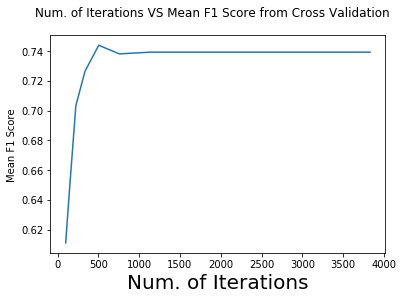

In [21]:
# Plotting Num. of Iterations VS Mean F1 Score from Cross Validation
fig_lr, ax_lr = plt.subplots()
ax_lr.plot(max_iter, f1_scores_logistic_regression)

# title and labels, setting initial sizes
fig_lr.suptitle('Num. of Iterations VS Mean F1 Score from Cross Validation', fontsize=12)
ax_lr.set_xlabel('Num. of Iterations', fontsize=10)
ax_lr.set_ylabel('Mean F1 Score', fontsize=10)

# setting label sizes after creation
ax_lr.xaxis.label.set_size(20)
plt.draw()

print("Highest Mean F1 Score = {f1_score} is for {iteration} iterations".format(
        f1_score=max(f1_scores_logistic_regression), 
        iteration=max_iter[f1_scores_logistic_regression.index(max(f1_scores_logistic_regression))]))

In [22]:
# Splitting the data
X_train,X_test,Y_train,Y_test = train_test_split(features, label, test_size=0.20, random_state=42)

# Applying Logistic Regression for final testing on X_test
logistic_regression = LogisticRegression(
                                        penalty='l2', 
                                        tol=0.0001, 
                                        C=1, 
                                        solver='lbfgs', 
                                        max_iter=1000, 
                                        multi_class='multinomial',
                                        n_jobs=2)
logistic_regression = logistic_regression.fit(X_train,Y_train.values.ravel())
Y_predicted_logistic_regression = logistic_regression.predict(X_test)

# F1 Score, Precision, Recall
Precision, Recall, F1score, Support = prfs(Y_test, Y_predicted_logistic_regression, average='macro', beta=1.0)
print("Values for Logistic Regression when test on X_test: ","\n\tPrecision ->",Precision,"\n\tRecall->",Recall,"\n\tF1score->",F1score)

Values for Logistic Regression when test on X_test:  
	Precision -> 0.8344933317456537 
	Recall-> 0.8187028657616893 
	F1score-> 0.8229291861922652


* Without Standardization : 
    * WIthout Balance in class_weight:

        * Values for Logistic Regression :   (Without Item Tag Hash)
            * Precision -> 0.6521012870247425  
            * Recall-> 0.5680687838857249  
            * F1score-> 0.5835475051264525

        * Values for Logistic Regression :  (With Item Tag Hash)
            * Precision -> 0.7183712121212121  
            * Recall-> 0.6446269427080347  
            * F1score-> 0.6663927628386265

    * With Class Balance :
        * Values for Logistic Regression :  (With Item Tag Hash)
            * Precision -> 0.5845743615967807  
            * Recall-> 0.6150927514877735  
            * F1score-> 0.5925326842895967
        
* With Standardization and Without Class Balance and with Item Tag Hash :
    * Values for Logistic Regression :  
        * Precision -> 0.8344933317456537 
        * Recall-> 0.8187028657616893 
        * F1score-> 0.8229291861922652

## Random Forset

In [23]:
# Splitting the data for cross valication
X_train,X_test,Y_train,Y_test = train_test_split(features, label, test_size=0.20, random_state=42)

# Cross Validation on Random Forest for Overfitting checking
random_forest = RandomForestClassifier(n_estimators=100, 
                                       criterion='gini',
                                       n_jobs=2
                                       )
cv_scores_rf = cross_val_score(random_forest, X_train, Y_train.values.ravel(), cv=3, scoring=f1_scorer)
print("Cross Validation F1 Scores for Random Forest : {rf_scores}".format(rf_scores=cv_scores_rf))


random_forest = random_forest.fit(X_train,Y_train.values.ravel())
Y_predicted_random_forest = random_forest.predict(X_test)

# F1 Score, Precision, Recall
Precision, Recall, F1score, Support = prfs(Y_test, Y_predicted_random_forest, average='macro', beta=1.0)
print("Values for Random Forest when tested on X_test: ","\n\tPrecision ->",Precision,"\n\tRecall->",Recall,"\n\tF1score->",F1score)

Cross Validation F1 Scores for Random Forest : [0.61249191 0.58522179 0.57932353]
Values for Random Forest when tested on X_test:  
	Precision -> 0.6692738633915105 
	Recall-> 0.659827623357035 
	F1score-> 0.6597162314660983


* Without Standardization : 
    * Values for random_forest :  (With Balanced class weights)
        * Precision -> 0.6837301587301587  
        * Recall-> 0.6090468102752327  
        * F1score-> 0.625970958535601

    * Values for random_forest :  (Without Balanced class weights) 
        * Precision -> 0.6767219067995767  
        * Recall-> 0.591782284355548  
        * F1score-> 0.612128218602207

* With Stadardization and Without class weight balance:
    * Values for Random Forest when tested on X_test:  
        * Precision -> 0.6362970362970362 
        * Recall-> 0.6088170652876534 
        * F1score-> 0.6173646098405385

## Adaboost

### Adaboost with Logistic Regressor as it weak learner

In [24]:
# Splitting the data for cross valication
X_train,X_test,Y_train,Y_test = train_test_split(features, label, test_size=0.20, random_state=42)

# Cross Validating on Adaboost with Logistic Regressor as its weak learners
adaboost_logistic_regression = AdaBoostClassifier(base_estimator=LogisticRegression(
                                                                penalty='l2', 
                                                                tol=0.0001, 
                                                                C=1, 
                                                                solver='lbfgs', 
                                                                max_iter=1000,
                                                                multi_class='multinomial',
                                                                n_jobs=2), 
                                                  n_estimators=50,
                                                  learning_rate=1)
cv_scores_adaboost_lr = cross_val_score(adaboost_logistic_regression, X_train, Y_train.values.ravel(), cv=3, scoring=f1_scorer) 
print("Cross Validation F1 Scores on Adaboost with Logistic Regressor as its weak learner :\n {cv_scores_adaboost_lr}".format(cv_scores_adaboost_lr=cv_scores_adaboost_lr))                                                                                                                      
                                                                                                                        
adaboost_logistic_regression = adaboost_logistic_regression.fit(X_train,Y_train.values.ravel())
Y_predicted_adaboost_logistic_regression = adaboost_logistic_regression.predict(X_test)

# F1 Score, Precision, Recall
Precision, Recall, F1score, Support = prfs(Y_test, Y_predicted_adaboost_logistic_regression, average='macro', beta=1.0)
print("Values for Adaboost with Logistic Regression when tested on X_test: ","\n\tPrecision ->",Precision,"\n\tRecall->",Recall,"\n\tF1score->",F1score)

Cross Validation F1 Scores on Adaboost with Logistic Regressor as its weak learner :
 [0.54759065 0.57051179 0.48144678]
Values for Adaboost with Logistic Regression when tested on X_test:  
	Precision -> 0.6146764346764346 
	Recall-> 0.6277828054298643 
	F1score-> 0.6156887924127499


### Adaboost with Random Forest as its weak learner

In [25]:
# Splitting the data for Cross validation
X_train,X_test,Y_train,Y_test = train_test_split(features, label, test_size=0.20, random_state=42)

# Cross Validating on Adaboost with Random Forest as its weak learners
adaboost_random_forest = AdaBoostClassifier(base_estimator=
                                                   RandomForestClassifier(
                                                       n_estimators=100, 
                                                       criterion='gini',
                                                       n_jobs=2
                                                        ), 
                                                  n_estimators=50,
                                                  learning_rate=1.0)

cv_scores_adaboost_rf = cross_val_score(adaboost_random_forest, X_train, Y_train.values.ravel(), cv=3, scoring=f1_scorer) 
print("Cross Validation F1 Scores on Adaboost with Random Forest as its weak learner :\n {cv_scores_adaboost_rf}".format(cv_scores_adaboost_rf=cv_scores_adaboost_rf))                                                                                                                      
                                                                                                                        
adaboost_random_forest = adaboost_random_forest.fit(X_train,Y_train.values.ravel())
Y_predicted_adaboost_random_forest = adaboost_random_forest.predict(X_test)

# F1 Score, Precision, Recall
Precision, Recall, F1score, Support = prfs(Y_test, Y_predicted_adaboost_random_forest, average='macro', beta=1.0)
print("Values for Adaboost with Random Forest when tested on X_test: ","\n\tPrecision ->",Precision,"\n\tRecall->",Recall,"\n\tF1score->",F1score)

Cross Validation F1 Scores on Adaboost with Random Forest as its weak learner :
 [0.60271099 0.55273634 0.6003049 ]
Values for Adaboost with Random Forest when tested on X_test:  
	Precision -> 0.7171239244864367 
	Recall-> 0.7222064210299505 
	F1score-> 0.7112935262081372


## Logistic Regression with PCA

In [26]:
# Setting up PCA to test f1 scores for different number of components
f1_scores_pca = []
num_components = [i for i in range(100, features.shape[1])]
for i in num_components:
    pca = PCA(n_components=i, svd_solver='full')
    reduced_features_array = pca.fit_transform(features)
    reduced_features = pd.DataFrame(reduced_features_array, columns=range(0, pca.n_components_))
    X_train_reduced,X_test_reduced,Y_train_reduced,Y_test_reduced = train_test_split(reduced_features, label, test_size=0.20, random_state=42)
    logistic_regression_pca = LogisticRegression(
                                        penalty='l2', 
                                        tol=0.0001, 
                                        C=1,
                                        solver='lbfgs', 
                                        max_iter=1000, 
                                        multi_class='multinomial',
                                        n_jobs=2)
    cv_scores_pca = cross_val_score(logistic_regression_pca,X_train_reduced,Y_train_reduced.values.ravel(),cv=3,scoring=f1_scorer)
    f1_scores_pca.append(cv_scores_pca)

Highest Mean F1 Score = 0.744132007534433 (i.e [0.71662304 0.73605616 0.77971682]) 
 is for 180 principle components


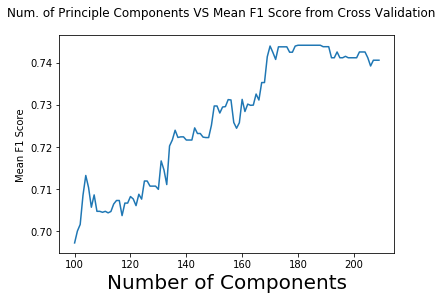

In [27]:
# Plotting Num. of Principle Components VS Mean F1 Score from Cross Validation
fig, ax = plt.subplots()
f1_scores_pca_mean = [sum(x)/3 for x in f1_scores_pca]
ax.plot(num_components, f1_scores_pca_mean)

# title and labels, setting initial sizes
fig.suptitle('Num. of Principle Components VS Mean F1 Score from Cross Validation', fontsize=12)
ax.set_xlabel('Number of Components', fontsize=10)
ax.set_ylabel('Mean F1 Score', fontsize=10)

# setting label sizes after creation
ax.xaxis.label.set_size(20)
plt.draw()

print("Highest Mean F1 Score = {f1_score} (i.e {f1_scores_list}) \n is for {num_component} principle components".format(
        f1_score=max(f1_scores_pca_mean),
        f1_scores_list=f1_scores_pca[f1_scores_pca_mean.index(max(f1_scores_pca_mean))],
        num_component=num_components[f1_scores_pca_mean.index(max(f1_scores_pca_mean))]))

In [28]:
# Running Cross Validation for n_components = 180
# Creating the data set in lower dimension
pca = PCA(n_components=180, svd_solver='full')
reduced_features_array = pca.fit_transform(features)
reduced_features = pd.DataFrame(reduced_features_array, columns=range(0, pca.n_components_))
# Creating the splits
X_train_reduced,X_test_reduced,Y_train_reduced,Y_test_reduced = train_test_split(reduced_features, label, test_size=0.20, random_state=42)
logistic_regression_pca = LogisticRegression(
                                    penalty='l2', 
                                    tol=0.0001, 
                                    C=1,
                                    solver='lbfgs', 
                                    max_iter=1000, 
                                    multi_class='multinomial',
                                    n_jobs=2)
# running cross validation
cv_scores_pca = cross_val_score(logistic_regression_pca,X_train_reduced,Y_train_reduced.values.ravel(),cv=3,scoring=f1_scorer) 
print("Cross Validation F1 Scores on Logistic Regression after PCA :\n {cv_scores_pca}".format(cv_scores_pca=cv_scores_pca))                                                                                                                      

# fitting the logistic regression now that pca has been applied and data set has been reduced to lower dimension
logistic_regression_pca = logistic_regression_pca.fit(X_train_reduced,Y_train_reduced.values.ravel())
Y_predicted_logistic_regression_pca = logistic_regression_pca.predict(X_test_reduced)
# F1 Score, Precision, Recall
Precision, Recall, F1score, Support = prfs(Y_test_reduced, Y_predicted_logistic_regression_pca, average='macro', beta=1.0)
print("Values for Logistic Regression with PCA when tested on X_test: ","\n\tPrecision ->",Precision,"\n\tRecall->",Recall,"\n\tF1score->",F1score)

Cross Validation F1 Scores on Logistic Regression after PCA :
 [0.71662304 0.73605616 0.77971682]
Values for Logistic Regression with PCA when tested on X_test:  
	Precision -> 0.8344933317456537 
	Recall-> 0.8187028657616893 
	F1score-> 0.8229291861922652


### Model Selection

    After looking at few models, we found that F1-Score(Macro) for following two models is maximum:

        1. Logistic Regression
        2. PCA on features followed by Logistic Regression
    
    Further, we find that both the models are giving out same `F1 Score = 0.8229291861922652`, following  would be the possible explanation :
    
        a. We assume that the direction in which data shows the most variation are the directions which are associated with our target variable `category_class`.
        
        b. By PCA, the key idea is that often a small number of principle components are enough to capture this variation of the dataset and its relationship with the target variable, further we choose the number of principle components which maximizes the value of F1 score in our training data.
        
        c. With the optimal value of number of principle components, we can safely say that we have captured almost all of the "useful" variation in our dataset which directly affects the target variable `category_class`. Also in process we have reduced the dimension of our dataset which would help mitigate overfitting.
        
        d. Now with, reduced data in dimension which capture the variace in that data "perfectly", we ran logistic regression with similar hyper parameters as before. With all of the data variation condensed in lower dimension we were bound to get similar (approximately same) results.

    Now for selecting the model, we shall be going ahead with PCA with Logistic Regression as it would generalize well as compared to normal Logistic Regression.

### Model Training And Prediction

In [29]:
# PCA on the training data 
pca = PCA(n_components=180, svd_solver='full')
reduced_features_array = pca.fit_transform(features)
reduced_features = pd.DataFrame(reduced_features_array, columns=range(0, pca.n_components_))

logistic_regression_pca = LogisticRegression(
                                    penalty='l2', 
                                    tol=0.0001, 
                                    C=1,
                                    solver='lbfgs', 
                                    max_iter=1000, 
                                    multi_class='multinomial',
                                    n_jobs=2)
# running cross validation
cv_scores_pca = cross_val_score(logistic_regression_pca,features,label.values.ravel(),cv=5,scoring=f1_scorer) 
print("Cross Validation F1 Scores on Logistic Regression after PCA :\n {cv_scores_pca}".format(cv_scores_pca=cv_scores_pca))                                                                                                                      

# fitting the logistic regression now that pca has been applied and data set has been reduced to lower dimension
logistic_regression_pca = logistic_regression_pca.fit(features, label.values.ravel())


Cross Validation F1 Scores on Logistic Regression after PCA :
 [0.80792802 0.89019041 0.77698718 0.78414267 0.82923687]


In [30]:
Y_predicted_logistic_regression_pca = logistic_regression_pca.predict(test_features)

In [31]:
predicted__df = pd.DataFrame(data=Y_predicted_logistic_regression_pca, columns=['category_class'])
predicted__df['item_id'] = test_data['item_id']
predicted__df['item_id'] = predicted__df['item_id'].astype(int)
predicted__df = predicted__df[['item_id', 'category_class']]

In [32]:
predicted__df.to_csv(path_or_buf=current_path + '/Data/prediction.csv', encoding='utf-8', index=False)